<a href="https://colab.research.google.com/github/SheshamJoseph/Deep-Learning-with-Tensorflow-ZTM/blob/main/04_transfer_learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 1: Feature Extraction

Transfer learning is a technique in machine learning in which knowledge learned from a task is re-used in order to boost performance on a related task. A common sample case is using the knowledge gained by a model that recognises cars to recognise trucks

In this Notebook we are going to cover:
* Introduction to Transfer learning with Tensorflow
* Using a small dataset to experiment faster(10% of training samples)
* Building a **Transffer learning feature extraction** model with TensorflowHub
* Use TensorBoard to track modelling experiments and results

In [1]:
# Are we using a GPU
!nvidia-smi

Thu Jan 18 21:43:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Download and become one with the data

In [2]:
# get the data(10% of 10 food classes data)
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-01-18 21:43:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   185MB/s    in 0.9s    

2024-01-18 21:43:43 (185 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# walk through the folder directory
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 10 director

In [4]:
# visualizing the some of the data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pathlib
import numpy as np
# get the class names

train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)
def plot_random_images(directory, classnames=class_names ):
    plt.figure(figsize=(10, 7))
    for i in range(9):
        # Setup the target directory
        target_class = random.choice(classnames)
        target_folder = directory + target_class
        # Get a random image
        random_image = random.sample(os.listdir(target_folder), 1)
        img = mpimg.imread(target_folder+'/'+random_image[0])
        # plot image
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(target_class)
        plt.axis("off")

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


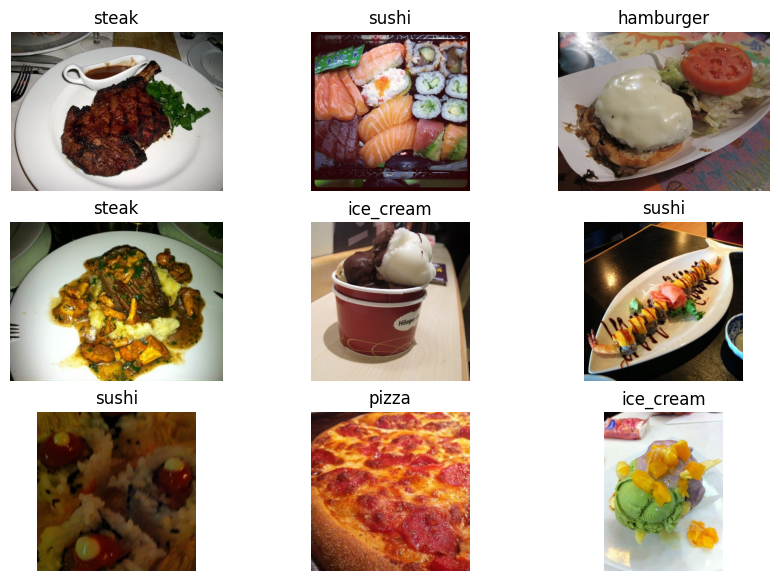

In [5]:
plot_random_images(train_dir)

## Creating data loader (preparing the data)

In [6]:
# setup data inputs
import tensorflow as tf
from tensorflow import keras

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

print("Training data")
train_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SHAPE
)

print("Testing data")
test_dataset = keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SHAPE
)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Training data
Found 750 files belonging to 10 classes.
Testing data
Found 2500 files belonging to 10 classes.


In [7]:
# number of classes
num_classes = 10

## Setting up callbacks (Things to run while our model trains)
Callbacks are extrra functionality you can add to your models to be performed during or after training.
Popular examples are:
*  Tracking experiments with the Tensorboard callback
* Model checkpoint with th ModelCheckpoint callback
* Stopping a modelfrom training before it trains too long and overfits with EarlyStopping callback

In [8]:
# create tensorboard callback (functionized because we need to create a new one
# for each model)
import datetime #when a model is run

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving Tensorboard lod file to {log_dir}")
    return tensorboard_callback


## Creating models using Tensorflow Hub
Tensorflow Hub holds pretrained models that can be uses for transfer learning.

Can be accessed at http://tfhub.dev


In [28]:
# Let's compare between RESnet and Efficientnet
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"


In [11]:
import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras import layers

In [12]:
# Create a create_model() function to create a model from a url
def create_model(model_url, num_classes=10):
    """
    Takes a Tensorflow hub Url and creates a Keras Sequential model with it.
    Agrs:
        model_url (str): A tensoflow hub feature extraction model url
        num_classes (int): Number of neurons in the output layer, should be equal to
        number of target classes. Default 10

    Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
    """
    # Download pretrained model and save it as a keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False, # freeze already learned weights
                                             name="feature_extraction_layer")

    # create the model
    model = keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=IMAGE_SHAPE+(3,)),
        feature_extractor_layer,
        # layers.Flatten(),
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])

    return model

### Creating and testing TfHub Resnet Feature Extraction model

In [13]:
# Create Resnet model
resnet_model = create_model(model_url=resnet_url,
                            num_classes=num_classes)

In [14]:
# compile our resnet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [15]:
# fit the model
resnet_hist = resnet_model.fit(train_dataset,
                               epochs=5,
                               steps_per_epoch=len(train_dataset),
                               validation_data=test_dataset,
                               validation_steps=len(test_dataset),
                               callbacks=[create_tensorboard_callback(
                                   dir_name='tensorflow_hub',
                                   experiment_name='resnet-v2'
                               )])

Saving Tensorboard lod file to tensorflow_hub/resnet-v2/240118-214416
Epoch 1/5
24/24 [==============================] - 28s 721ms/step - loss: 1.9716 - accuracy: 0.3573 - val_loss: 1.2107 - val_accuracy: 0.6160
Epoch 2/5
24/24 [==============================] - 8s 359ms/step - loss: 0.9102 - accuracy: 0.7293 - val_loss: 0.8481 - val_accuracy: 0.7300
Epoch 3/5
24/24 [==============================] - 8s 363ms/step - loss: 0.6308 - accuracy: 0.8173 - val_loss: 0.7341 - val_accuracy: 0.7528
Epoch 4/5
24/24 [==============================] - 9s 366ms/step - loss: 0.4723 - accuracy: 0.8613 - val_loss: 0.6863 - val_accuracy: 0.7676
Epoch 5/5
24/24 [==============================] - 9s 369ms/step - loss: 0.3756 - accuracy: 0.9133 - val_loss: 0.6552 - val_accuracy: 0.7736


In [16]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [17]:
# Create functiom to plot our loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Plots loss and accuracy curves for training and validation metrics

    Args:
        history: Tensorflow History object
    Returns:
        None
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

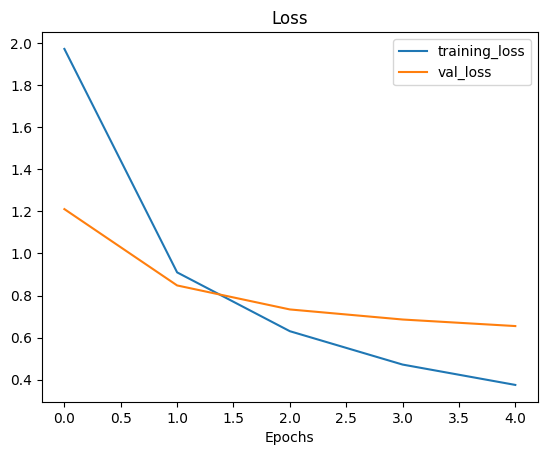

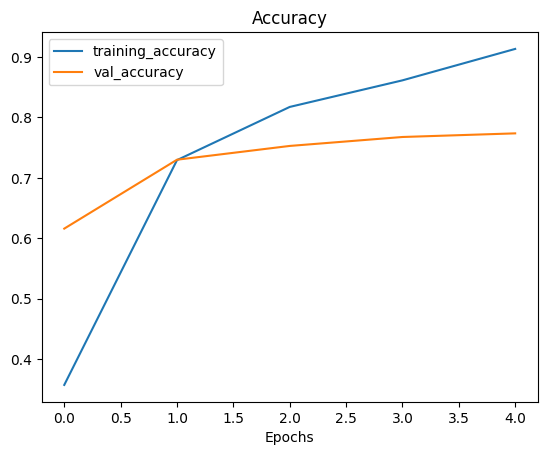

In [18]:
plot_loss_curves(resnet_hist)

### Creating and testing TfHub EfficientNet Feature Extraction model

In [29]:
# create model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=num_classes)



In [30]:
# efficientnet_model.build([None, 224, 224, 3])  # Batch input shape.

In [31]:
# compile
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

In [32]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [33]:
# fit model
efficientnet_hist = efficientnet_model.fit(train_dataset,
                               epochs=5,
                               steps_per_epoch=len(train_dataset),
                               validation_data=test_dataset,
                               validation_steps=len(test_dataset),
                               callbacks=[create_tensorboard_callback(
                                   dir_name='tensorflow_hub',
                                   experiment_name='eficientnetb0'
                               )])

Saving Tensorboard lod file to tensorflow_hub/eficientnetb0/240118-221010
Epoch 1/5
24/24 [==============================] - 15s 329ms/step - loss: 1.9719 - accuracy: 0.3293 - val_loss: 1.5234 - val_accuracy: 0.6100
Epoch 2/5
24/24 [==============================] - 5s 200ms/step - loss: 1.3137 - accuracy: 0.6747 - val_loss: 1.1390 - val_accuracy: 0.7036
Epoch 3/5
24/24 [==============================] - 5s 204ms/step - loss: 1.0106 - accuracy: 0.7507 - val_loss: 0.9647 - val_accuracy: 0.7388
Epoch 4/5
24/24 [==============================] - 5s 201ms/step - loss: 0.8472 - accuracy: 0.7920 - val_loss: 0.8699 - val_accuracy: 0.7576
Epoch 5/5
24/24 [==============================] - 5s 199ms/step - loss: 0.7389 - accuracy: 0.8227 - val_loss: 0.8103 - val_accuracy: 0.7688


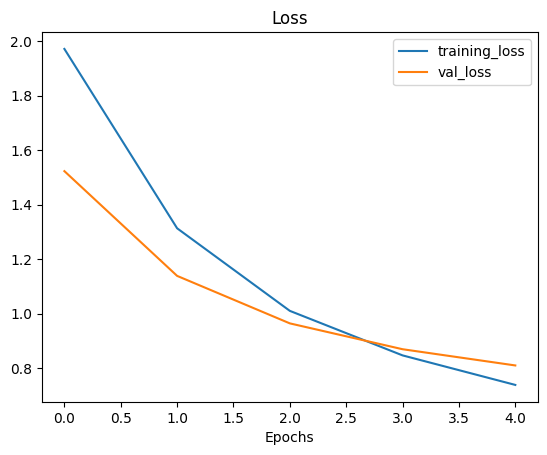

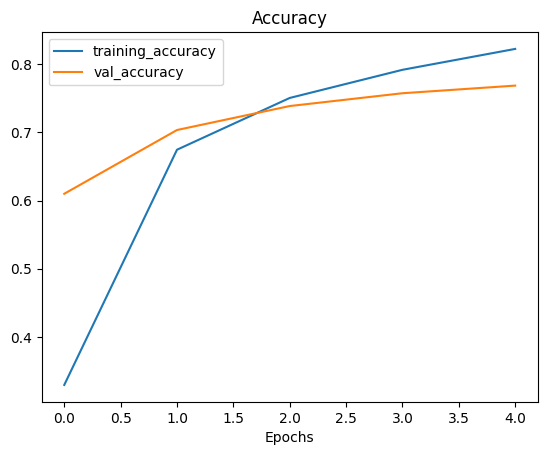

In [34]:
plot_loss_curves(efficientnet_hist)

In [35]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [36]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


## The Different types of transfer learning
We have already seen an example of transfer learning from the two models above. But just to list the types, we have:
* **'As is'** transfer learning - using an existing model without applying changes
* **'Feature extraction'** transfer learning - use the pretrained patterns of an existing model and adjust the output layer for your own problem
* **'Fine-tuning'** transfer learning - use the prelearned patterns of an existing model and 'fine-tune' many or all of the underlying layers (including new layers)